# Demand Timeseries Forecast

Mert Burak Burabak

Dataset: https://www.kaggle.com/c/store-sales-time-series-forecasting

Used kaggle notebooks: https://www.kaggle.com/dmitryfomkin/ts-lr-xgb-time-features-ny-pay-days/data

In [1]:
#local the kaggle.json to content(colab.reaearch.google.com)
#!pip install -q kaggle
#!mkdir -p ~/.kaggle
#!cp /content/kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json
#!kaggle competitions download -c store-sales-time-series-forecasting
#!unzip /content/train.csv.zip
#!unzip /content/transactions.csv.zip
#!rm -r /content/train.csv.zip
#!rm -r /content/transactions.csv.zip

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from scipy import stats
from itertools import product
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor

# Datasets

## Train dataset

In [2]:
df_train = pd.read_csv('./content/train.csv', parse_dates=['date'], infer_datetime_format=True)
df_train['date'] = df_train.date.dt.to_period('D')
store_sales = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()
prom = (store_sales.groupby('date').mean().squeeze())['onpromotion'].to_frame()
average_sales = (store_sales.groupby('date').mean().squeeze())['sales'].to_frame()
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Test Dataset

In [3]:
df_test = pd.read_csv('./content/test.csv', parse_dates=['date'])
df_test['date'] = df_test.date.dt.to_period('D')
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Store Dataset

In [4]:
stores = pd.read_csv('./content/stores.csv', index_col='store_nbr')
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Oil Dataset

In [5]:
oil = pd.read_csv('./content/oil.csv', parse_dates=['date'])
oil = oil.set_index('date').to_period('d')
oil.fillna(method='ffill', inplace=True)
oil['ma_oil'] = oil.dcoilwtico.rolling(7).mean()
oil.dcoilwtico.fillna(method='ffill', inplace=True)
oil.ma_oil.fillna(method='ffill', inplace=True)
oil.tail()

,dcoilwtico,ma_oil
date,,
2017-08-25,47.65,47.720000
2017-08-28,46.40,47.624286
2017-08-29,46.46,47.320000
2017-08-30,45.96,47.115714
2017-08-31,47.26,47.060000


## Holidays Dataset

In [6]:
holiday = pd.read_csv('./content/holidays_events.csv', parse_dates=['date'])
holiday = holiday.set_index('date').to_period('D')
holiday.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Transaction Dataset

In [7]:
transaction = pd.read_csv('./content/transactions.csv', parse_dates=['date'])
transaction = transaction.set_index('date').to_period('d')
transaction.tail()

,store_nbr,transactions
date,,
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255
2017-08-15,53,932
2017-08-15,54,802


# Plots

## Date

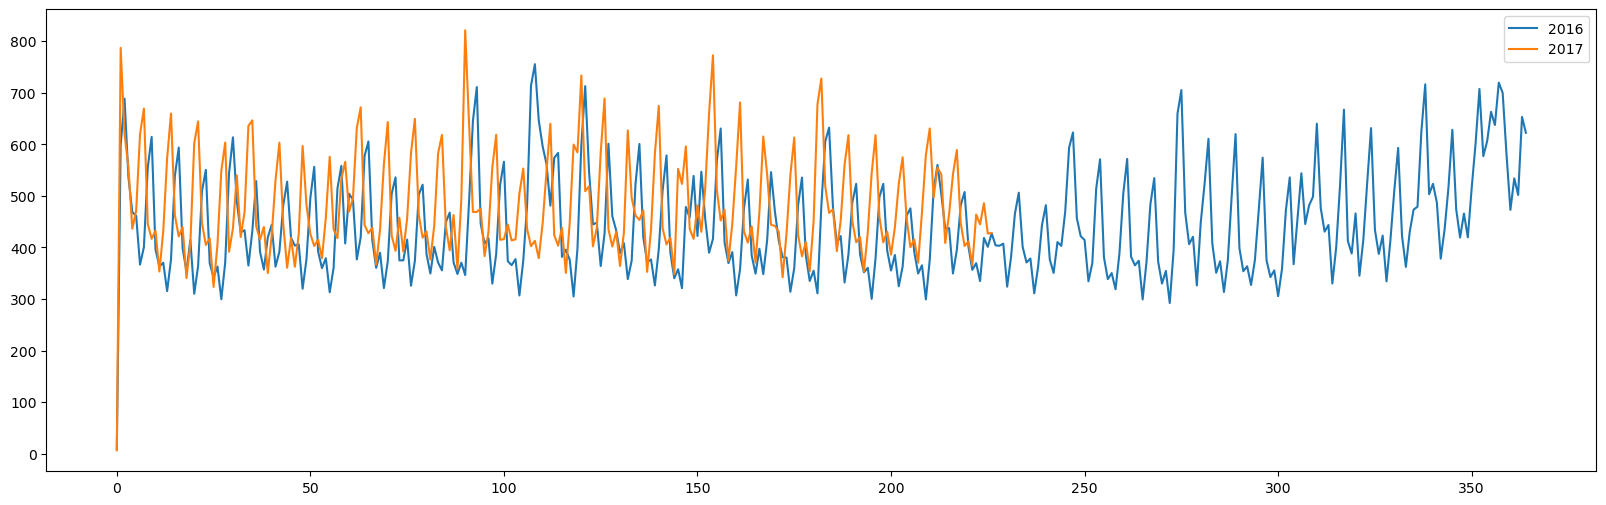

In [48]:
sales_plot = average_sales.copy()
plt.figure(figsize=(20,6))
plt.plot(sales_plot.loc['2016']['sales'].values, label='2016')
plt.plot(sales_plot.loc['2017']['sales'].values, label='2017')
plt.legend()
plt.show()

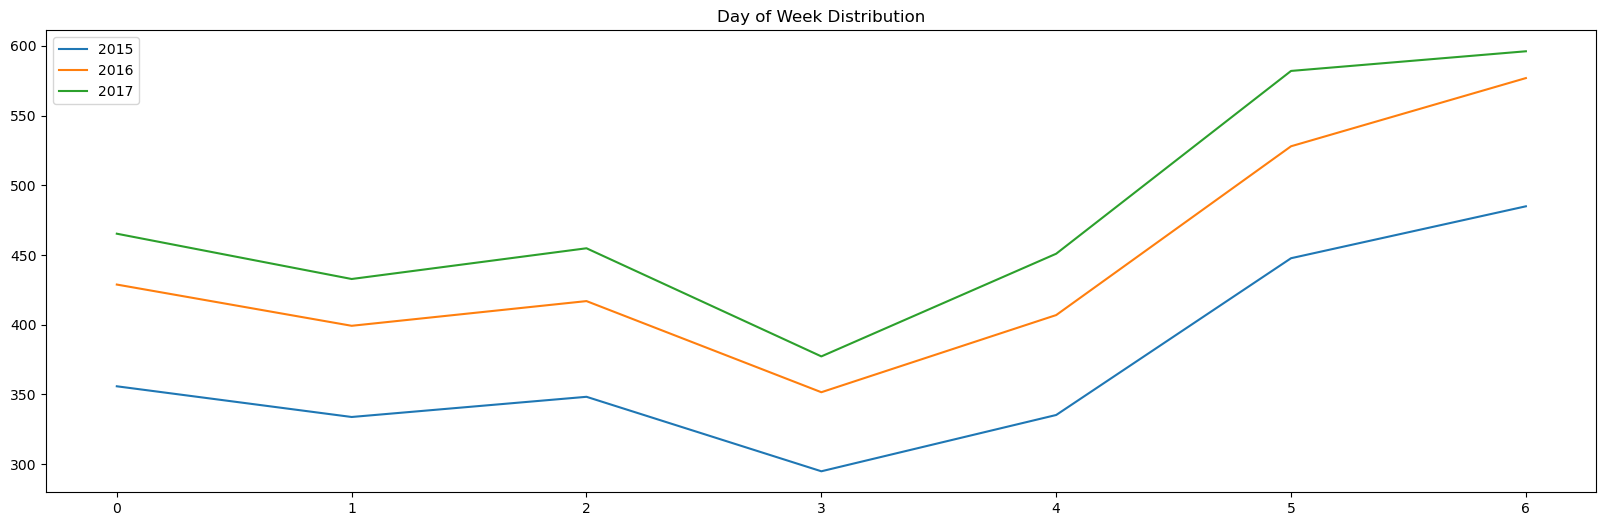

In [49]:
b_days = sales_plot.copy()
b_days['dayofweek'] = b_days.index.dayofweek
plt.figure(figsize=(20,6))
plt.plot(b_days.loc['2015'].groupby('dayofweek')['sales'].mean().values, label='2015')
plt.plot(b_days.loc['2016'].groupby('dayofweek')['sales'].mean().values, label='2016')
plt.plot(b_days.loc['2017'].groupby('dayofweek')['sales'].mean().values, label='2017')
plt.title("Day of Week Distribution")
plt.legend()
plt.show()

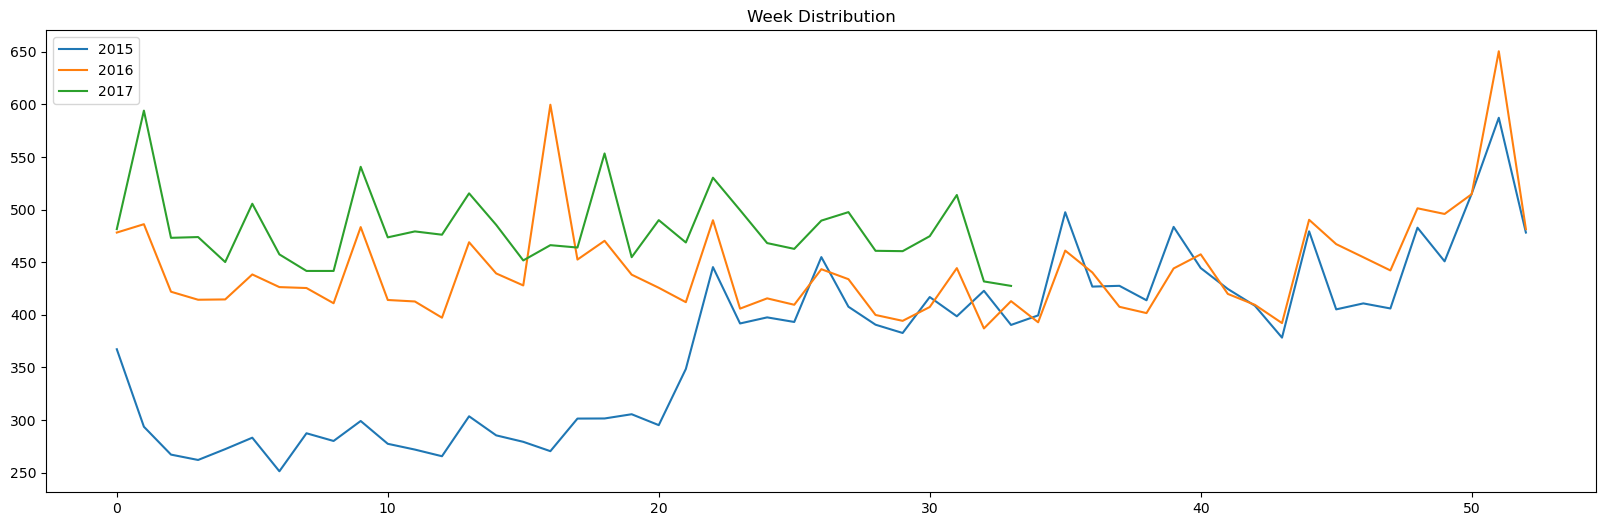

In [50]:
week = sales_plot.resample('w').mean()
plt.figure(figsize=(20,6))
plt.plot(week.loc['2015']['sales'].values, label='2015')
plt.plot(week.loc['2016']['sales'].values, label='2016')
plt.plot(week.loc['2017']['sales'].values, label='2017')
plt.title("Week Distribution")
plt.legend()
plt.show()

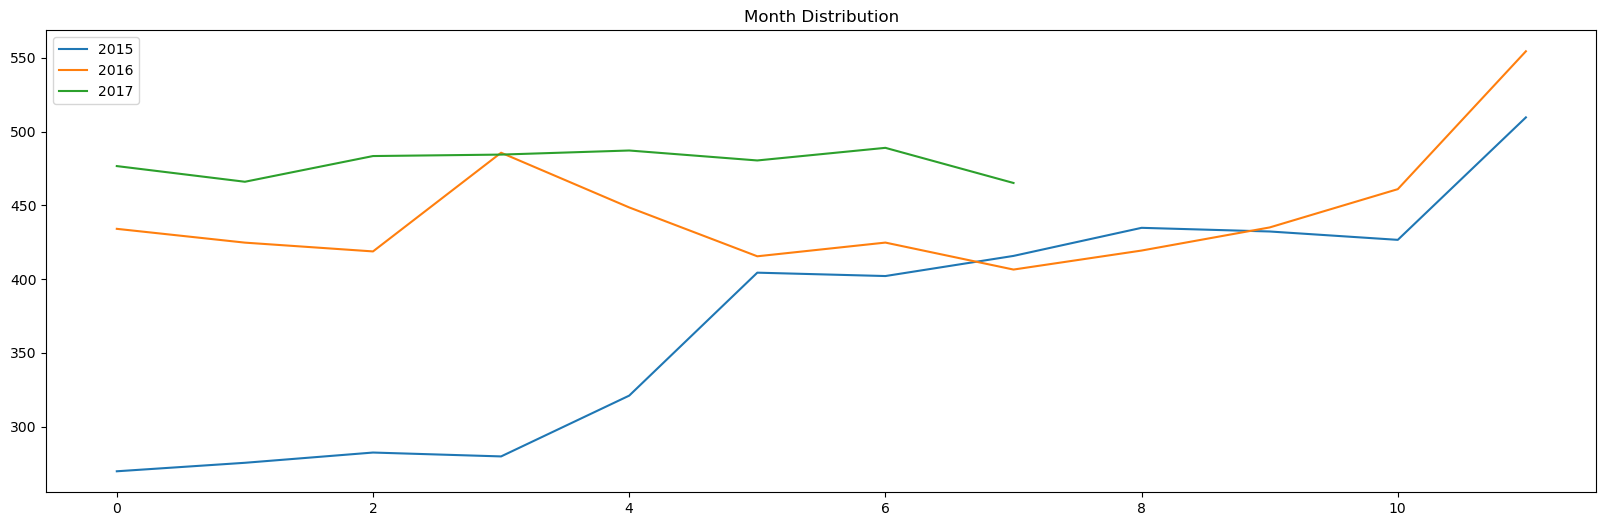

In [51]:
month = sales_plot.resample('m').mean()
plt.figure(figsize=(20,6))
plt.plot(month.loc['2015']['sales'].values, label='2015')
plt.plot(month.loc['2016']['sales'].values, label='2016')
plt.plot(month.loc['2017']['sales'].values, label='2017')
plt.title("Month Distribution")
plt.legend()
plt.show()

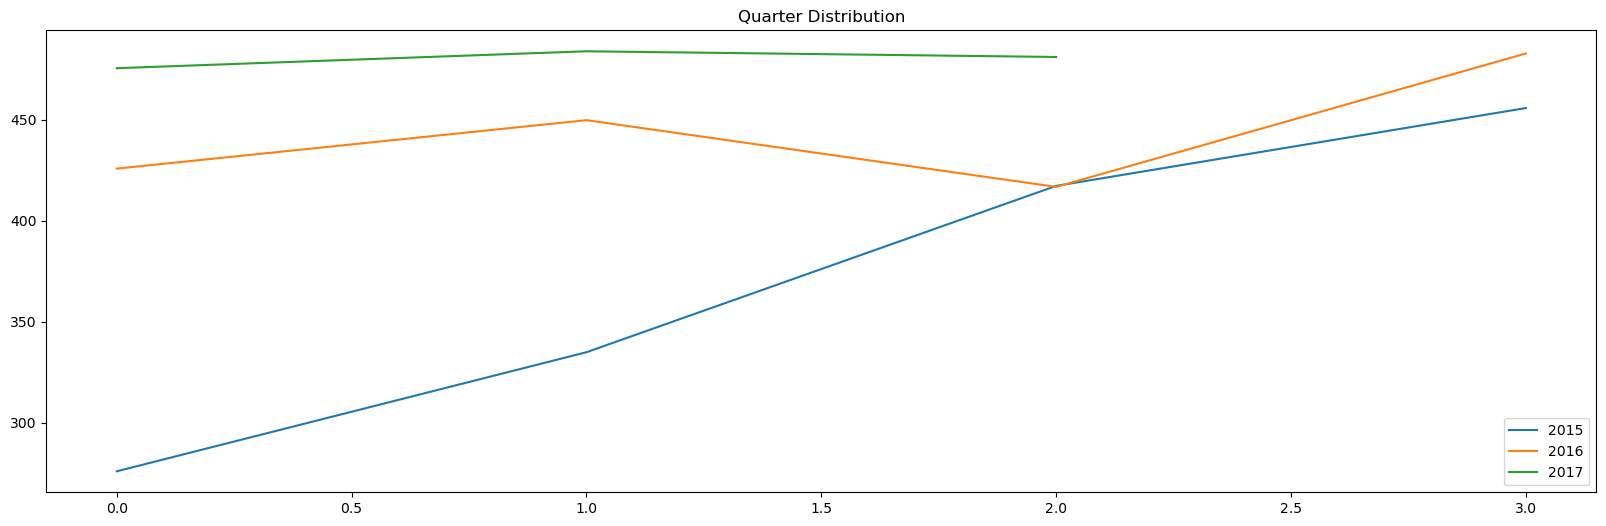

In [52]:
quarter= sales_plot.resample('q').mean()
plt.figure(figsize=(20,6))
plt.plot(quarter.loc['2015']['sales'].values, label='2015')
plt.plot(quarter.loc['2016']['sales'].values, label='2016')
plt.plot(quarter.loc['2017']['sales'].values, label='2017')
plt.title("Quarter Distribution")
plt.legend()
plt.show()

## Holidays

In [13]:
holiday.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [14]:
holiday.type.value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [15]:
holiday.locale.value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

In [16]:
holidays = holiday.loc[holiday.index.isin(sales_plot.index)]
plt.figure(figsize=(20,6))
plt.plot_date((holidays.index).to_timestamp(), sales_plot.loc[holidays.index].sales, color='C3')
plt.plot(sales_plot.index.to_timestamp(), sales_plot.sales);
plt.title("Holiday Distribution on Sales")

Text(0.5, 1.0, 'Holiday Distribution on Sales')

In [17]:
def hol_plot(df, col='C3', lab='N'):
    plt.plot_date(df.loc['2016'].index.to_timestamp(), sales_plot.loc[df.loc['2016'].index].sales, color=col, label=lab)
    plt.plot(sales_plot.loc['2016'].index.to_timestamp(), sales_plot.loc['2016'].sales, color='silver')



holiday_nat = holidays.loc[(holidays.locale == 'National') & (holidays.transferred == False) & (holidays.type != 'Work Day')]
holiday_loc = holidays.loc[(holidays.locale == 'Local') & (holidays.transferred == False) & (holidays.type != 'Work Day')]
holiday_reg = holidays.loc[(holidays.locale == 'Regional') & (holidays.transferred == False) & (holidays.type != 'Work Day')]
holiday_trans = holidays.loc[(holidays.transferred == True)]
plt.figure(figsize=(20,6))
hol_plot(holiday_nat, col='orange', lab='national')
hol_plot(holiday_loc, col='black', lab='local')
hol_plot(holiday_reg, col='red', lab='regional')
hol_plot(holiday_trans, col='blue', lab='transferred')
plt.title("Locality of the Holdays on Sales")
plt.legend()



## Promotion

In [18]:
scale = MinMaxScaler()



plt.figure(figsize=(20,6))
plt.plot(scale.fit_transform(sales_plot.loc['2016'].values), label='sales')
plt.plot(scale.fit_transform(prom.loc['2016'].values), label='prom')
plt.legend();
prom.loc['2016'].corrwith(sales_plot.loc['2016'].sales)



onpromotion    0.14014
dtype: float64

## Transaction

In [19]:


trans = transaction.resample('d').mean()['transactions'].to_frame()
plt.figure(figsize=(20,6))
plt.plot(scale.fit_transform(sales_plot.loc['2016'].values), label='sales')
plt.plot(scale.fit_transform(trans.loc['2016'].values), label='transactions')
plt.legend();
trans.loc['2016'].corrwith(sales_plot.loc['2016'].sales)



transactions    0.835026
dtype: float64

## Oil

In [20]:
oils = oil.resample('d').mean().fillna(method='ffill')
plt.figure(figsize=(20,6))
plt.plot(scale.fit_transform(sales_plot.loc['2017'].values), label='sales')
plt.plot(scale.fit_transform(oils.loc['2017'].values), label='oil')
plt.legend();
oils.loc['2017'].corrwith(sales_plot.loc['2017'].sales)

dcoilwtico    0.011973
ma_oil       -0.005919
dtype: float64

# Baseline Model (Linear Regression)

In [21]:
X_train = df_train.copy()
X_test = df_test.copy()
full_df = pd.concat([X_train, X_test])
full_df.reset_index(drop=True, inplace=True)
X_store = full_df.set_index(['store_nbr', 'family', 'date']).sort_index()
X_prom = (X_store.groupby('date').mean().squeeze())['onpromotion'].to_frame()
av_sales = (X_store.groupby('date').mean().squeeze())['sales'].to_frame()
full_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [22]:
# for time features
def creat_time_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['weekofyear'] = df.index.week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    X = df.copy()
    return X

In [23]:
def model_cv (X, y):
    cv = TimeSeriesSplit()
    model = LinearRegression()
    result = cross_validate(model, X.loc[:'2017-07'],y.loc[:'2017-07'], cv=cv,scoring=["neg_mean_absolute_error", "neg_mean_squared_log_error"], return_estimator=True)
    mae = -result["test_neg_mean_absolute_error"]
    rmsle = np.sqrt(- result["test_neg_mean_squared_log_error"])
    print('mae = {:.3f}\nrmsle = {:.3f}'.format(mae.mean(), rmsle.mean()))

In [24]:
def X_y(df):
    df = df.copy()
    X = df.loc['2017':].dropna().drop(columns=['sales'])
    y = df.loc['2017':]['sales'].dropna()
    return X,y

## Only date features  (LR)

In [25]:
X_full = creat_time_features(av_sales)
X, y = X_y(X_full)
X_test = X_full.loc['2017-08-16':].drop(columns=['sales'])
model_cv(X,y);

mae = 60.951
rmsle = 0.156


## Date Features + Dummies (LR)

In [26]:
X_dum = pd.get_dummies(X, columns=['dayofweek'])
X_test = pd.get_dummies(X_test, columns=['dayofweek'])
model_cv(X_dum,y)

mae = 39.877
rmsle = 0.112


## Date Features + Dummies + new_year (LR)

In [27]:
X_hol = X_dum.copy()
X_hol['new_year'] = (X_hol.index.dayofyear ==1).astype('int')
X_test['new_year'] = (X_test.index.dayofyear ==1).astype('int')
model_cv(X_hol,y)

mae = 39.877
rmsle = 0.112


## Date Features + Dummies + new_year + pay_days

In [28]:
X_pay = X_hol.copy()
X_pay['day_in_m'] = X_pay.index.days_in_month
X_pay['pay_day'] = (X_pay.index.day == 16) | (X_pay.index.day == 1) | (X_pay.index.day == 14) | (X_pay.index.day == X_pay['day_in_m'] - 1) | (X_pay.index.day == 15) | (X_pay.index.day == X_pay['day_in_m'])
X_pay.drop(columns='day_in_m', inplace=True, axis=1)
X_test['day_in_m'] = X_test.index.days_in_month
X_test['pay_day'] = (X_test.index.day == 15) | (X_test.index.day == X_test['day_in_m']) | (X_test.index.day == 16) | (X_test.index.day == 1) | (X_test.index.day == 14) | (X_test.index.day == X_test['day_in_m'] - 1)
X_test.drop(columns='day_in_m', inplace=True, axis=1)
model_cv(X_pay,y)



mae = 40.124
rmsle = 0.111


## Date Features + Dummies + new_year + pay_days + Holidays

In [29]:
hol = holiday.loc['2017'].loc[holiday.loc['2017'].locale.isin(['National', 'Regional'])]
hol['hol'] = 1
hol.loc[hol.type == 'Transfer', 'hol'] = 1
hol.loc[(hol.type == 'Holiday') & (hol.transferred == False), 'hol'] = 1
hol.loc[(hol.type == 'Holiday') & (hol.transferred == True ), 'hol'] = 0
hol = pd.get_dummies(hol.drop(columns=['locale','locale_name','description','transferred']), columns=['type'])
X_weakend = X_pay.copy()
X_weakend = pd.concat([X_weakend, hol.loc[:'2017-08-16']], axis=1).fillna(0)
X_weakend.loc[X_weakend.index.dayofweek.isin([5,6]), 'hol'] = 1
X_test = pd.concat([X_test, hol.loc['2017-08-16':'2017-08']], axis=1).fillna(0)
X_test.loc[X_test.index.dayofweek.isin([5,6]), 'hol'] = 1
model_cv(X_weakend,y)

mae = 40.496
rmsle = 0.110


## Date Features + Dummies + new_year + pay_days + Holidays + Oil

In [30]:
X_oil = X_weakend.copy()
X_oil = pd.merge(X_oil, oil, how='left', on='date')
X_test = pd.merge(X_test, oil, how='left', on='date')
X_oil.dcoilwtico.fillna(method='ffill', inplace=True)
X_oil.ma_oil.fillna(method='ffill', inplace=True)
X_test.dcoilwtico.fillna(method='ffill', inplace=True)
X_test.ma_oil.fillna(method='ffill', inplace=True)
X_oil.dcoilwtico.fillna(53.75, inplace=True)
X_oil.ma_oil.fillna(53.164, inplace=True)
model_cv(X_oil,y)

mae = 49.893
rmsle = 0.132


In [31]:
model = LinearRegression()
X_for_subm = X_oil.loc['2017':]
y_ = X_store.loc[:,:,'2017':].dropna()['sales'].to_frame().unstack(['store_nbr', 'family'])

model.fit(X_for_subm, y_)
y_pred = pd.DataFrame(model.predict(X_for_subm), columns=y_.columns, index=X_for_subm.index)
y_pred[y_pred < 0 ] = 0
plt.figure(figsize=(20,6));
plt.plot(y_.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
plt.plot(y_pred.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
mae = mean_absolute_error(y_pred.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values,y_.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
msle = mean_squared_log_error(y_pred.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values,y_.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
print('mae = {:.3f}\nrmsle = {:.3f}'.format(mae, np.sqrt(msle)))
y_submit = pd.DataFrame(model.predict(X_test), columns=y_.columns, index=X_test.index)
y_submit_ = y_submit.stack(['store_nbr', 'family'])
y_submit_.loc[y_submit_.sales < 0] = 0
df_test_ = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
y_submit_ = y_submit_.join(df_test_.id).reindex(columns=['id', 'sales'])
y_submit_.to_csv('submission_2.csv', index=False)
y_submit_


mae = 168.024
rmsle = 0.105


id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     3.757043
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.857575
                     BEVERAGES                   3000891  2327.163402
                     BOOKS                       3000892     0.575842
...                                                  ...          ...
2017-08-31 54        POULTRY                     3029263    60.070639
                     PREPARED FOODS              3029264    84.281929
                     PRODUCE                     3029265   496.582954
                     SCHOOL AND OFFICE SUPPLIES  3029266     2.191925
                     SEAFOOD                     3029267     3.496572

[28512 rows x 2 columns]

With submission_2 (Linear Regression): 
- Kaggle Leaderboard rmsle: 0.47537
- Rank: 155 / 892

# MLP Model

In [32]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data


X_for_subm['day'] = pd.to_datetime(X_for_subm.index.to_timestamp()).day
X_for_subm['is_month_start'] = pd.to_datetime(X_for_subm.index.to_timestamp()).is_month_start
X_for_subm['is_month_end'] = pd.to_datetime(X_for_subm.index.to_timestamp()).is_month_end
X_for_subm = encode(X_for_subm, 'dayofyear', 365)
X_for_subm = encode(X_for_subm, 'month', 12)

X_test['day'] = pd.to_datetime(X_test.index.to_timestamp()).day
X_test['is_month_start'] = pd.to_datetime(X_test.index.to_timestamp()).is_month_start
X_test['is_month_end'] = pd.to_datetime(X_test.index.to_timestamp()).is_month_end
X_test = encode(X_test, 'dayofyear', 365)
X_test = encode(X_test, 'month', 12)

/dev/shm/mert.burabak/.conda/envs/mert_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/dev/shm/mert.burabak/.conda/envs/mert_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/dev/shm/mert.burabak/.conda/envs/mert_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
import keras
import keras.backend as K

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=100,  restore_best_weights=True)
]

# define model
model = Sequential()
model.add(Dense(400, activation='relu', input_dim=X_for_subm.shape[1]))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu', input_dim=X_for_subm.shape[1]))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', input_dim=X_for_subm.shape[1]))
model.add(BatchNormalization())
model.add(Dense(y_.shape[1]))
model.compile(optimizer='adam', loss='mse')
history = model.fit(K.constant(X_for_subm.to_numpy()), K.constant(y_),
                    epochs=5000,
                    verbose=0,
                    validation_split=0.1,
                    callbacks=my_callbacks)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [35]:
mlp_predict = pd.DataFrame(model.predict(K.constant(X_for_subm.to_numpy())), columns=y_.columns, index=X_for_subm.index)
mlp_predict[mlp_predict < 0] = 0

In [36]:
plt.figure(figsize=(20,6))
plt.plot(y_.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
plt.plot(mlp_predict.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)

In [37]:
mae = mean_absolute_error(mlp_predict.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values,y_.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
msle = mean_squared_log_error(mlp_predict.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values,y_.loc(axis=1)['sales',1, 'PRODUCE'].loc['2017'].values)
print('mae = {:.3f}\nrmsle = {:.3f}'.format(mae, np.sqrt(msle)))

mae = 1708.837
rmsle = 1.915


In [38]:
y_submit = pd.DataFrame(model.predict(K.constant(X_test.to_numpy())), columns=y_.columns, index=X_test.index)
y_submit_ = y_submit.stack(['store_nbr', 'family'])
y_submit_.loc[y_submit_.sales < 0] = 0
df_test_ = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
y_submit_ = y_submit_.join(df_test_.id).reindex(columns=['id', 'sales'])
y_submit_.to_csv('submission_3.csv', index=False)

with submission_3(MLP):
- Kaggle Leaderboard rmsle: 0.58688

# LSTM Model

In [32]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

from tensorflow.keras.layers import LSTM, TimeDistributed, Input, Dense, Dropout, BatchNormalization, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
import tensorflow as tf

import time

In [43]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# for time features
def creat_time_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['weekofyear'] = df.index.week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['day'] = df.index.day
    df['is_month_start'] = pd.to_datetime(df.index.to_timestamp()).is_month_start
    df['is_month_end'] = pd.to_datetime(df.index.to_timestamp()).is_month_end
    df = encode(df, 'dayofyear', 365)
    df = encode(df, 'month', 12)
    X = df.copy()
    return X

def X_y(df):
    df = df.copy()
    X = df.loc['2013':].dropna().drop(columns=['sales'])
    y = df.loc['2013':]['sales'].dropna()
    return X,y

def get_lstm_data():
  X_full = creat_time_features(av_sales)
  X, y = X_y(X_full)
  X_test = X_full.loc['2017-08-16':].drop(columns=['sales'])
  X = pd.get_dummies(X, columns=['dayofweek'])
  X_test = pd.get_dummies(X_test, columns=['dayofweek'])
  X['new_year'] = (X.index.dayofyear ==1).astype('int')
  X_test['new_year'] = (X_test.index.dayofyear ==1).astype('int')
  X['day_in_m'] = X.index.days_in_month
  X['pay_day'] = (X.index.day == 16) | (X.index.day == 1) | (X.index.day == 14) | (X.index.day == X['day_in_m'] - 1) | (X.index.day == 15) | (X.index.day == X['day_in_m'])
  X.drop(columns='day_in_m', inplace=True, axis=1)
  X_test['day_in_m'] = X_test.index.days_in_month
  X_test['pay_day'] = (X_test.index.day == 15) | (X_test.index.day == X_test['day_in_m']) | (X_test.index.day == 16) | (X_test.index.day == 1) | (X_test.index.day == 14) | (X_test.index.day == X_test['day_in_m'] - 1)
  X_test.drop(columns='day_in_m', inplace=True, axis=1)
  hol = holiday[holiday.locale.isin(['National', 'Regional'])]
  hol['hol'] = 1
  hol.loc[hol.type == 'Transfer', 'hol'] = 1
  hol.loc[(hol.type == 'Holiday') & (hol.transferred == False), 'hol'] = 1
  hol.loc[(hol.type == 'Holiday') & (hol.transferred == True ), 'hol'] = 0
  hol = pd.get_dummies(hol.drop(columns=['locale','locale_name','description','transferred']), columns=['type'])
  X = pd.merge(X, hol, how='left', on='date').fillna(0)
  X.loc[X.index.dayofweek.isin([5,6]), 'hol'] = 1
  X_test = pd.merge(X_test, hol, how='left', on='date').fillna(0)
  X_test.loc[X_test.index.dayofweek.isin([5,6]), 'hol'] = 1
  X = pd.merge(X, oil, how='left', on='date')
  X_test = pd.merge(X_test, oil, how='left', on='date')
  X.dcoilwtico.fillna(method='ffill', inplace=True)
  X.ma_oil.fillna(method='ffill', inplace=True)
  X_test.dcoilwtico.fillna(method='ffill', inplace=True)
  X_test.ma_oil.fillna(method='ffill', inplace=True)
  X.dcoilwtico.fillna(method='bfill', inplace=True)
  X.ma_oil.fillna(method='bfill', inplace=True)
  X_test.dcoilwtico.fillna(method='bfill', inplace=True)
  X_test.ma_oil.fillna(method='bfill', inplace=True)
  y_ = X_store.dropna()['sales'].to_frame().unstack(['store_nbr', 'family'])
  X['date'] = X.index.to_timestamp()
  X.drop_duplicates(subset=['date'], inplace=True)
  X.drop(['date'], axis=1, inplace=True)
  
  #Weekly
  fourier = CalendarFourier(freq='W', order=4)
  dp = DeterministicProcess(index=np.append(np.array(y_.index),(X_test.index)),
                            constant=False,
                            period=30,
                            order=2,
                            seasonal=True,
                            additional_terms=[fourier],
                            drop=True)
  
  
  additional_date_feauteres = dp.in_sample() 
  additional_date_feauteres.index.name = 'date'

  X = pd.merge(X, additional_date_feauteres, how='left', on='date')
  X_test = pd.merge(X_test, additional_date_feauteres, how='left', on='date')
  
  return X, y_, X_test

def split_series(series, n_past, n_future):
#
# n_past ==> no of past observations
#
# n_future ==> no of future observations 
#
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series.iloc[window_start:past_end, :], series.iloc[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

def split_series_v2(series, y_, n_past, n_future):
#
# n_past ==> no of past observations
#
# n_future ==> no of future observations 
#
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    input, output = series.iloc[past_end:future_end, :], y_.iloc[past_end:future_end, :]
    X.append(input)
    y.append(output)
  return np.array(X), np.array(y)

def get_model(do_rate, EPOCHS, verbosity):
    
    #Left Branch
    left_input = Input(shape=[X_tr_1.shape[1], X_tr_1.shape[2]], name='left_input')
    left_branch_1 = LSTM(units=512, return_sequences=True, name='left_branch_1')(left_input)
    left_branch_1 = BatchNormalization()(left_branch_1)
    left_branch_2 = LSTM(units=256, return_sequences=True, name='left_branch_2')(left_branch_1)
    left_branch_2 = BatchNormalization()(left_branch_2)
    left_branch_3 = LSTM(units=128, return_sequences=True, name='left_branch_3')(left_branch_2)
    left_branch_3 = BatchNormalization()(left_branch_3)
    left_branch_4 = TimeDistributed(Dense(n_features), name='left_branch_4')(left_branch_3)
    
    #Right Branch
    right_input = Input(shape=[X_tr_2.shape[1], X_tr_2.shape[2]], name='right_input')
    right_branch_1 = LSTM(units=512, return_sequences=True, name='right_branch_1')(right_input)
    right_branch_1 = BatchNormalization()(right_branch_1)
    right_branch_2 = LSTM(units=256, return_sequences=True, name='right_branch_2')(right_branch_1)
    right_branch_2 = BatchNormalization()(right_branch_2)
    right_branch_3 = LSTM(units=128, return_sequences=True, name='right_branch_3')(right_branch_2)
    right_branch_3 = BatchNormalization()(right_branch_3)
    right_branch_4 = TimeDistributed(Dense(n_features), name='right_branch_4')(right_branch_3)
    
    
    #Merge Branches
    x = concatenate([left_branch_4, right_branch_4, left_input, right_input])
    x = Dense(512, kernel_initializer='normal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(do_rate)(x)
    x = Dense(256, kernel_initializer='normal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(do_rate)(x)
    x = Dense(128, kernel_initializer='normal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(do_rate)(x)
    x = concatenate([x, left_input, right_input])
    predictions = Dense(n_features, kernel_initializer='normal',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01), activation='linear', name='main_output')(x)
    
    #Model
    model = Model(inputs=[left_input, right_input], outputs=predictions)
    
    #Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name='Adam'),
                  loss='mse')
    
    #History
    my_callbacks = [
        EarlyStopping(patience=200, monitor='val_loss',restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)
    
    ]
    
    
    model_history = model.fit([K.constant(X_tr_1), K.constant(X_tr_2)],
                              K.constant(y_tr),
                              validation_data=([K.constant(X_val_1), K.constant(X_val_2)], K.constant(y_val)),
                              epochs=EPOCHS,
                              callbacks=my_callbacks,
                              batch_size=64,
                              verbose=verbosity)
    
    return model, model_history

In [44]:
X, y_, X_test = get_lstm_data()
X = X[X.index.to_timestamp() >= pd.to_datetime('2017-01-01')]
y_ = y_[y_.index.to_timestamp() >= pd.to_datetime('2017-01-01')]

n_past =16
n_future = 16
n_features = 54 * 33 # num of features

#Now converting the data via split_series function
X_train_2, y_train = split_series(y_, n_past, n_future)
X_train_1, _ = split_series_v2(X, y_, n_past, n_future)

test_ds = [K.constant(X_test.to_numpy().reshape(1,n_past,X.shape[1])), K.constant(y_.tail(n_past).to_numpy().reshape(1,n_past, n_features))]

/dev/shm/mert.burabak/.conda/envs/mert_venv/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/dev/shm/mert.burabak/.conda/envs/mert_venv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [46]:
do_rate = 0.1
EPOCHS = 2000
verbosity = 0
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
losses = []
fold = 1

for train_index, valid_index in kf.split(X_train_1):
    tic = time.time()
    
    #Train-Validation split
    X_tr_1, X_tr_2 = X_train_1[train_index], X_train_2[train_index]
    X_val_1, X_val_2 = X_train_1[valid_index], X_train_2[valid_index]
    y_tr, y_val = y_train[train_index], y_train[valid_index]


    #Model Fitting
    model, history = get_model(do_rate, EPOCHS, verbosity)

    #Model Evaluate
    print("Fold {0} val loss: {1}".format(fold, model.evaluate([K.constant(X_val_1), K.constant(X_val_2)], K.constant(y_val)), verbose=verbosity))
    losses.append(model.evaluate([K.constant(X_val_1), K.constant(X_val_2)], K.constant(y_val), verbose=verbosity))
    
    #Prediction
    y_submit = model.predict(test_ds)
    y_submit[y_submit < 0] = 0
    results.append(y_submit[0])
    
    tac = time.time()
    print("time elapsed for FOLD {0} is {1} minutes".format(fold, round((tac-tic)/60,2)))
    fold += 1
print("------------")
print("Val Loss mean: ", np.mean(losses))

2/2 [==============================] - 0s 35ms/step - loss: 44946.1953
Fold 1 val loss: 44946.1953125
time elapsed for FOLD 1 is 29.51 minutes
2/2 [==============================] - 0s 40ms/step - loss: 43326.5000
Fold 2 val loss: 43326.5
time elapsed for FOLD 2 is 30.01 minutes
2/2 [==============================] - 0s 36ms/step - loss: 85354.8672
Fold 3 val loss: 85354.8671875
time elapsed for FOLD 3 is 30.31 minutes
2/2 [==============================] - 0s 41ms/step - loss: 158242.7969
Fold 4 val loss: 158242.796875
time elapsed for FOLD 4 is 5.09 minutes
2/2 [==============================] - 0s 32ms/step - loss: 41641.6680
Fold 5 val loss: 41641.66796875
time elapsed for FOLD 5 is 28.78 minutes
------------
Val Loss mean:  74702.40546875


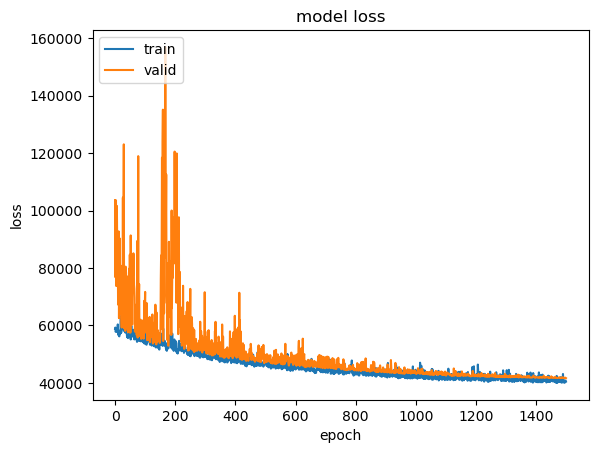

In [60]:
# summarize history for loss
plt.plot(history.history['loss'][-1500:])
plt.plot(history.history['val_loss'][-1500:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [61]:
y_submit = pd.DataFrame(np.mean(results,axis=0), columns=y_.columns, index=X_test.index)
y_submit_ = y_submit.stack(['store_nbr', 'family'])
y_submit_.loc[y_submit_.sales < 0] = 0
df_test_ = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
y_submit_ = y_submit_.join(df_test_.id).reindex(columns=['id', 'sales'])
y_submit_.to_csv('submission_6.csv', index=False)

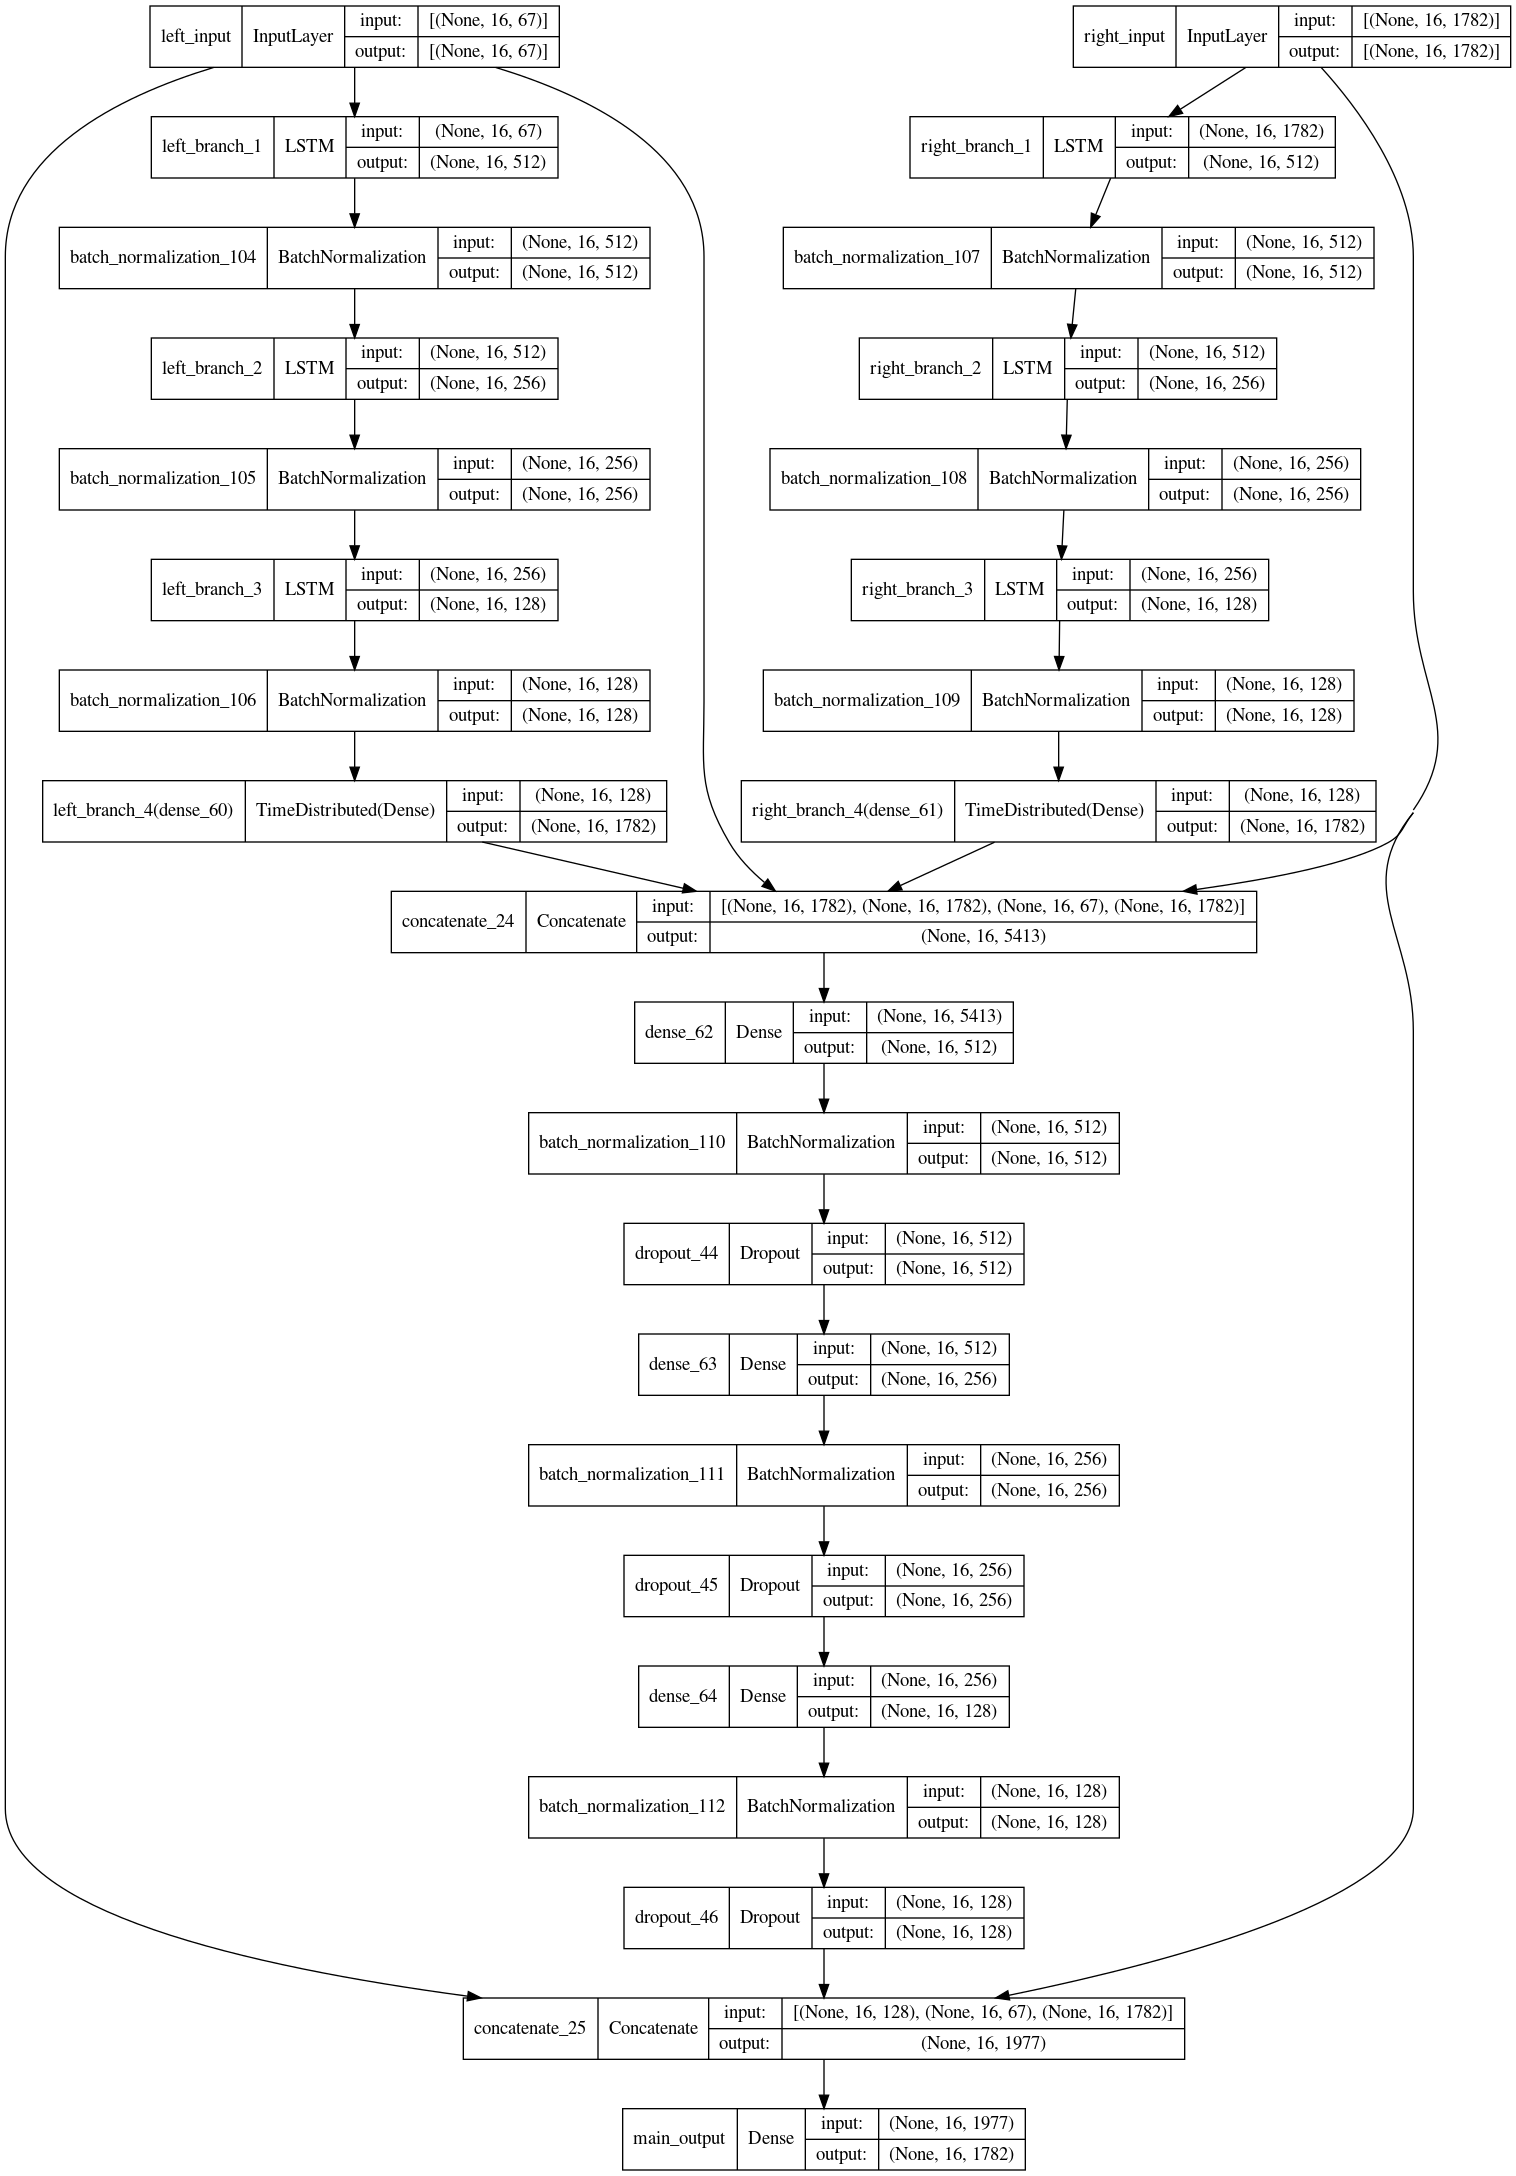

In [66]:
dot_img_file = './content/model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

For hyper-parameter tuning, tried options:

    - batch_size: [32, 64, 128, 256]
    - learning_rate: [0.001, 0.01, 0.05, 0.1]
    - epochs: [1000, 2000, 5000]
    
For architecture optimization, tried options:

    - drop_rate: [0.1, 0.2, 0.5]
    - l1: [0.001, 0.01, 0.1]
    - l2: [0.001, 0.01, 0.1]
    - activation: ['relu', 'tanh']
    

Kaggle Result: 
- rmsle: 0.46310 (3% improvement)